In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import os

### Data Prepare Class :

In [20]:
class DataPrepare:
    def __init__(self, dataset, test_split=0, batch_size=0, validation_split=.0, shuffle=False):
        self.num_samples = dataset[0].shape[0]
        dsIndx = np.arange(self.num_samples)
        if shuffle:
            np.random.shuffle(dsIndx)
        self.dataset = dataset[0][dsIndx], dataset[1][dsIndx]
        self.num_valid = int(self.num_samples * validation_split)
        self.num_test  = int(self.num_samples * test_split)
        self.num_train = self.num_samples - self.num_test - self.num_valid
        if batch_size == 0:
            self.batch_size = self.num_samples
            self.num_batchs = 1
        else:
            self.batch_size = batch_size   
            self.num_batchs = self.num_train // batch_size
            if self.num_train % batch_size != 0:
                self.num_batchs += 1 
        if self.num_valid:
            self.validations = self.dataset[0][self.num_train:self.num_train+self.num_valid], self.dataset[1][self.num_train:self.num_train+self.num_valid]
        else:
            self.validations = 0
        if self.num_test:
            self.test = self.dataset[0][self.num_train+self.num_valid::], self.dataset[1][self.num_train+self.num_valid::]
        self.train = self.dataset[0][0:self.num_train], self.dataset[1][0:self.num_train]

            
    def __iter__(self):
        for i in range(0, self.num_train, self.batch_size):
            yield (self.train[0][i:i+self.batch_size], self.train[1][i:i+self.batch_size]) 
            
    def __len__(self):
        return self.num_batchs
    
    def info(self):
        print('Number of Samples: {} (# Batchs : {})\n | # Train: {} | # Validation: {} | # Test: {}'.format
             (self.num_samples, self.num_batchs, self.num_train, self.num_valid, self.num_test))

### Layers Classes :

In [46]:
class ReLU:
    def __init__(self):
        self.learnable = None
    def forward (self, x):
        self.old_x = x.copy()
        return np.clip(self.old_x, 0, None)
    def backward(self, grad):
        return np.where(self.old_x > 0, grad,0)

class Sigmoid:
    def __init__(self):
        self.learnable = None
    def forward(self, x):
        self.y = 1 / (1 + np.exp(-x))
        return self.y
    def backward(self, grad):
        return self.y * (1 - self.y) * grad

class Softmax:
    def __init__(self):
        self.learnable = None
    def forward(self, x):
        n_exp = np.exp(x - x.max())
        self.y = n_exp / np.sum(n_exp, axis=1, keepdims=True)
        return self.y
    def backward(self, grad):
        return self.y*(grad - np.sum(grad*self.y, axis=1, keepdims=True))
    
class Dropout:
    def __init__(self, keep_prob):
        self.learnable = None
        self.parameter = keep_prob
    def forward(self, x):
        self.dropout = np.random.binomial(1, self.parameter, size=(x.shape[0], x.shape[1]))
        return np.multiply(x, self.dropout) / self.parameter
    def backward(self, grad):
        return np.multiply(grad, self.dropout) 
    
class BatchNormalization:
    def __init__(self, num_input):
        gamma = np.ones(num_input)
        beta = np.zeros(num_input)
        self.learnable = [gamma, beta]
        self.regularizer = None
        self.cache = []
    def forward(self, x):
        gamma, beta = self.learnable
        mu = np.mean(x, axis=0)
        var = np.var(x, axis=0)
        x_norm = (x - mu) / np.sqrt(var + 1e-8)
        self.Cache = (x, x_norm, mu, var)
        return gamma * x_norm + beta
    def backward(self, grad):
        gamma, beta = self.learnable
        x, x_norm, mu, var = self.Cache
        N, D = x.shape
        x_mu = x - mu
        std_inv = 1. / np.sqrt(var + 1e-8)
        dx_norm = grad * gamma
        dvar = np.sum(dx_norm * x_mu, axis=0) * -.5 * std_inv**3
        dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2. * x_mu, axis=0)
        grad_gamma = np.sum(grad * x_norm, axis=0)
        grad_beta = np.sum(grad, axis=0)
        self.gradient = [grad_gamma, grad_beta]
        return (dx_norm * std_inv) + (dvar * 2 * x_mu / N) + (dmu / N)

class Linear:
    def __init__(self, num_input, num_output, name=None, kernel_regularizer=None):
        weight = np.random.randn(num_input, num_output)*np.sqrt(2 / num_input)
        bias = np.zeros((1, num_output))
        self.learnable = [weight, bias]
        self.cache = []
        if kernel_regularizer:
            self.regularizer = kernel_regularizer
        else:
            self.regularizer = None
    def forward(self, x):
        weights, biases = self.learnable
        if self.regularizer:
            self.regularizer_penalty = self.regularizer.equation(weights)
        self.old_x = x.copy()
        return np.dot(x, weights) + biases
    def backward(self, grad):
        weights, biases = self.learnable
        grad_w = np.dot(self.old_x.T, grad) / self.old_x.shape[0]
        grad_b = grad.mean(axis=0)
        if self.regularizer:
            grad_w += self.regularizer.gradient(weights)
        self.gradient = [grad_w, grad_b]
        return np.dot(grad, weights.T)

In [23]:
class regularizers:  
    class l1:
        def __init__(self, rate):
            self.rate = rate
        def equation(self, weight_matrix):
            return self.rate * np.sum(np.abs(weight_matrix))
        def gradient(self, weight_matrix):
            return self.rate * np.sign(weight_matrix)
    
    class l2:
        def __init__(self, rate):
            self.rate = rate
        def equation(self, weight_matrix):
            return self.rate * np.sum(np.power(weight_matrix, 2))
        def gradient(self, weight_matrix):
            return self.rate * weight_matrix * 2  

### Loss Classes :

In [24]:
class Mean_Squared_Error:
    def forward(self, y_hat, y):
        self.R = y_hat - y
        return np.mean(np.power((self.R), 2)) / 2
    def backward(self):
        return self.R
    
class Mean_Absolute_Error:
    def forward(self, y_hat, y):
        self.y_hat = y_hat
        self.y = y
        return np.mean(np.abs(y_hat - y))
    def backward(self):
        return np.where(self.y_hat > self.y, +1, -1)

class Huber:
    def __init__(self, delta=1.0):
        self.delta = delta
    def forward(self, y_hat, y):
        self.R = y_hat - y
        mse = np.mean(np.power(self.R, 2)) / 2
        mae = np.abs(self.R)
        return np.where(y_hat > y, mse, (self.delta * mae) - (self.delta**2)/2)
    def backward(self):
        return np.where(np.abs(self.R) <= self.delta, self.R, np.sign(self.R) * self.delta)

class Binary_CrossEntropy:
    def forward(self, y_hat, y):
        self.y_hat = y_hat.clip(min=1e-8, max=None)
        self.y = y
        return np.where(y==1, -np.log(y_hat), -np.log(1- y_hat))
    def backward(self):
        return  np.where(self.y==1, self.y_hat-1, self.y_hat)

class Categorical_CrossEntropy:
    def forward(self, y_hat, y):
        self.y_hat = y_hat.clip(min=1e-8, max=None)
        self.y = y
        return (np.where(y==1, -np.log(self.y_hat), 0)).sum(axis=1)
    def backward(self):
        return np.where(self.y==1, -1 / self.y_hat, 0)

class Sparse_Categorical_CrossEntropy:
    def forward(self, y_hat, y):
        self.y_hat = y_hat.clip(min=1e-8, max=None)
        self.y = y
        return -np.sum(np.log(self.y_hat[range(y.shape[0]),y])) / y.shape[0]
    def backward(self):
        y_hot = np.zeros(self.y_hat.shape)
        y_hot[range(self.y.shape[0]),self.y] = 1
        return np.where(y_hot==1, -1 / self.y_hat, 0)

class Kullback_Leibler_Divergence:
    def forward(self, y_hat, y):
        self.y_hat = y_hat.clip(min=1e-8, max=None)
        self.y = y
        self.entropy = -np.sum(y * np.log(y))
        self.cross_entropy = -np.sum(y * np.log(y_hat))
        return self.entropy - self.cross_entropy
    def backward(self):
        return  np.where(self.y==1, self.y_hat-1, self.y_hat)

### Optimizers Classes :

In [62]:
class SGD:
    def __init__(self, model, learning_rate, momentom=.9):
        self.model = model
        self.lr = learning_rate
        self.momentom = momentom
        for layer in self.model.layers:
            if layer.learnable:
                for parameter in layer.learnable:
                    layer.cache.append(0.)
    def step(self):
        for layer in self.model.layers:
            if layer.learnable:
                for i, _ in enumerate(layer.learnable):
                    value =    layer.learnable[i]
                    gradinet = layer.gradient[i]
                    velocity = layer.cache[i]
                    
                    velocity = self.momentom * velocity + (1-self.momentom) * gradinet
                    value -= self.lr * velocity
                    
                    layer.learnable[i] = value 
                    layer.gradient[i] = gradinet 
                    layer.cache[i] = velocity

class RMSProp:
    def __init__(self, model, learning_rate, beta=.9):
        self.model = model
        self.lr = learning_rate
        self.beta = beta
        for layer in self.model.layers:
            if layer.learnable:
                for parameter in layer.learnable:
                    layer.cache.append(0.)       
    def step(self):
        for layer in self.model.layers:
            if layer.learnable:
                for i, _ in enumerate(layer.learnable):
                    value =    layer.learnable[i]
                    gradinet = layer.gradient[i]
                    s = layer.cache[i]
                    
                    s = self.beta + (1-self.beta) * np.power(gradinet, 2)
                    value -= (self.lr / np.sqrt(s + 1e-8)) * gradinet
                    
                    layer.learnable[i] = value 
                    layer.gradient[i] = gradinet 
                    layer.cache[i] = s

class Adam:
    def __init__(self, model, learning_rate, beta=[.9, .999]):
        self.model = model
        self.lr = learning_rate
        self.beta = beta
        self.epoch = 0
        for layer in self.model.layers:
            if layer.learnable:
                for parameter in layer.learnable:
                    layer.cache.append([0., 0., 0., 0.])     
    def step(self):
        self.epoch += 1
        for layer in self.model.layers:
            if layer.learnable:
                for i, _ in enumerate(layer.learnable):
                    value =    layer.learnable[i]
                    gradinet = layer.gradient[i]
                    m, v, m_hat, v_hat = layer.cache[i]
                    
                    m = self.beta[0] * m + (1-self.beta[0]) * gradinet
                    v = self.beta[1] * v + (1-self.beta[1]) * np.power(gradinet, 2)
                    m_hat = m / (1 - np.power(self.beta[0], self.epoch))
                    v_hat = v / (1 - np.power(self.beta[1], self.epoch))
                    value -= self.lr * m_hat / np.sqrt(v_hat + 1e-8)
                    
                    layer.learnable[i] = value 
                    layer.gradient[i] = gradinet 
                    layer.cache[i] = [m, v, m_hat, v_hat]

### Model :

In [35]:
class Model:
    def __init__(self, layers, cost):
        self.layers = layers
        self.cost = cost
    def loss(self, y_hat, y):
        penalty = 0.
        for layer in self.layers:
            if layer.learnable:
                if layer.regularizer:
                    penalty += layer.regularizer_penalty
        return self.cost.forward(y_hat, y) + penalty
    def forward(self, x, train=False):
        for layer in self.layers:
            if train:
                x = layer.forward(x)
            else:
                if type(layer) == Dropout:
                    continue
                x = layer.forward(x)
        return x
    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)

## Train & Test :

In [26]:
def train(model, data, optimizer, epochs, verbose=1, trend_plot=False):
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []
    for e in range(epochs):
        iter_loss = 0.
        iter_accuracy = 0.
        for inputs, targets in data:
            predicts = model.forward(inputs, train=True)
            iter_loss += model.loss(predicts, targets).mean()
            iter_accuracy += (np.argmax(predicts,axis=1)  == np.argmax(targets,axis=1)).mean() 
#             iter_accuracy += (np.argmax(predicts,axis=1)  == targets).mean()
#             iter_accuracy += (np.where(predicts>=.5, 1, 0) == targets[:,None]).mean()
            model.backward()
            optimizer.step()
        iter_loss /= len(data)
        iter_accuracy /= len(data)
        train_loss.append(iter_loss)
        train_accuracy.append(iter_accuracy)
        
        valid_info = ''
        if data.validations:
            x, y = data.validations
            p = model.forward(x)
            valid_loss.append(model.loss(p, y).mean())
            valid_accuracy.append((np.argmax(p,axis=1)  == np.argmax(y,axis=1)).mean())
#             valid_accuracy.append((np.argmax(p,axis=1)  == y).mean())
#             valid_accuracy.append((np.where(p>=.5, 1, 0) == targets[:,None]).mean())
            valid_info = ' Validation Loss: {:.4f}, Accuracy: {:.1f}%'.format(valid_loss[-1], valid_accuracy[-1]*100)
            
        if e % verbose == 0:
            print('Epoch[{}], Training Loss: {:.4f}, Accuracy: {:.1f}%{}'.format(
                   e, iter_loss, iter_accuracy*100, valid_info))
    print('DONE TRAINING!')
    if trend_plot:
        plt.figure(figsize=(5,5))
        plt.plot(train_loss, label = 'Trainig Loss')
        plt.plot(valid_loss, label = 'Validation Loss')
        plt.legend()
        plt.show()

        plt.figure(figsize=(5,5))
        plt.plot(train_accuracy, label = 'Trainig Accuracy')
        plt.plot(valid_accuracy, label = 'Validation Accuracy')
        plt.legend()
        plt.show()

In [27]:
def test(model, data):
    x, y = data
    p = model.forward(x)
    accuracy = (np.argmax(p,axis=1)  == np.argmax(y,axis=1)).mean()
#     accuracy = (np.argmax(p,axis=1)  == y).mean()
#     accuracy = (np.where(p>=.5, 1, 0) == targets[:,None]).mean()
    print('Test Accuracy: {:.1f}%'.format(accuracy*100))

#### Load data :

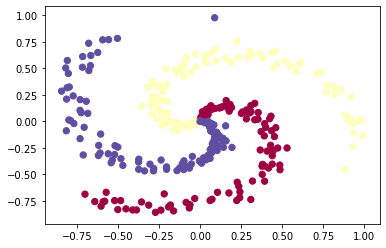

(300, 2) (300,)


In [17]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
inputs = np.zeros((N*K,D)) # data matrix (each row = single example)
targets = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    inputs[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    targets[ix] = j

# # lets visualize the data:
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets, s=40, cmap=plt.cm.Spectral)
plt.show()
X = inputs
Y = targets
print(X.shape, Y.shape)

In [28]:
from sklearn.datasets import load_boston
X, Y = load_boston(return_X_y=True)
Y = Y[:,None]
X = (X - X.mean()) / X.std()
print(X.shape, Y.shape)

(506, 13) (506, 1)


In [ ]:
from sklearn.datasets import fetch_openml
X, Y = fetch_openml('mnist_784', version=1, return_X_y=True)
Y = Y.astype(int)
print(X.shape, Y.shape)

#### Prepared Data :

In [29]:
preparedData = DataPrepare((X,Y), test_split=.10, batch_size=0, validation_split=.01, shuffle=True)
preparedData.info()

Number of Samples: 506 (# Batchs : 1)
 | # Train: 451 | # Validation: 5 | # Test: 50


#### Architecture :

In [60]:
np.random.seed(0)
reg = regularizers.l1(0.00)
layers = [
    Linear(13, 64, kernel_regularizer=reg),
    ReLU(),
    BatchNormalization(64),
    Linear(64, 64, kernel_regularizer=reg),
    ReLU(),
    BatchNormalization(64),
    Linear(64, 1)
]
net = Model(layers, cost=Mean_Squared_Error())
optimizer = Adam(net, learning_rate=0.01)
train(net, preparedData, optimizer, epochs=10000, verbose=1000, trend_plot=True)
# test(net, preparedData.test)

Epoch[0], Training Loss: 290.5105, Accuracy: 100.0% Validation Loss: 687.4535, Accuracy: 100.0%
Epoch[1000], Training Loss: 0.8379, Accuracy: 100.0% Validation Loss: 220.9467, Accuracy: 100.0%


KeyboardInterrupt: 

In [17]:
net.layers[0]